<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V7_UFL_RFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [ ]:
!pip show lightgbm | grep 'Version: 4.6.0' || pip install lightgbm==4.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.0 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [ ]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.0 MB/s eta 0:00:00


In [ ]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
# 📂 Cargar datos
file_path = '/content/260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# 🎯 Selección de variable objetivo
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = input("Introduce la variable objetivo para la regresión: ")
assert objective_var in ['kgDM/ha', 'kgCP/ha', 'UFL/ha'], "Variable no válida."

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']
Introduce la variable objetivo para la regresión: UFL/ha


In [ ]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [ ]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 15307.825496


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


# 📈 Basic Models Evaluation

In [ ]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.834738630440265
RMSE: 1203.9624360443177
MAE: 910.5409841799619
MAPE: 5.969446522380431

XGBoost Basic
R2: 0.8234331847321763
RMSE: 1244.4624736056649
MAE: 923.7873215247845
MAPE: 6.027205195179914

AdaBoost Basic
R2: 0.7312399024222449
RMSE: 1535.3580073500789
MAE: 1186.118961339117
MAPE: 8.000910800315165

Random Forest Basic
R2: 0.8374702255612887
RMSE: 1193.9708655736695
MAE: 899.4818224137935
MAPE: 5.904722144497695


### Variable importance for RMS global reduction

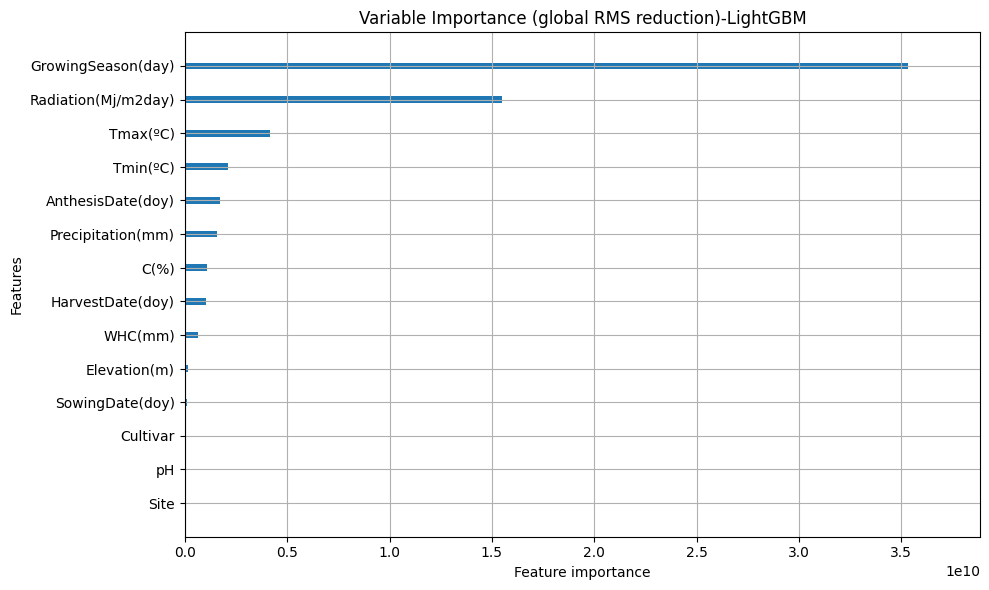

In [ ]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

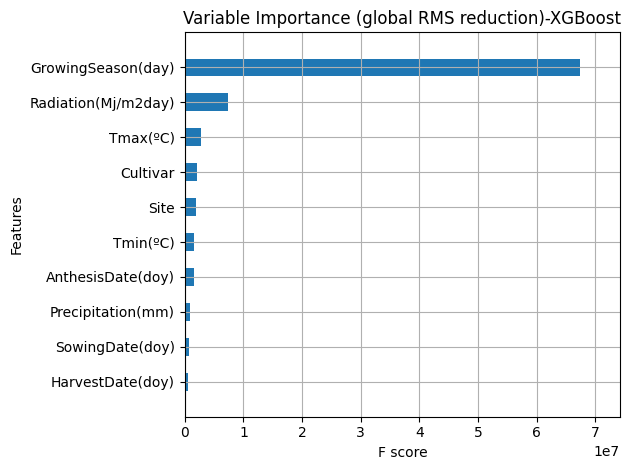

In [ ]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

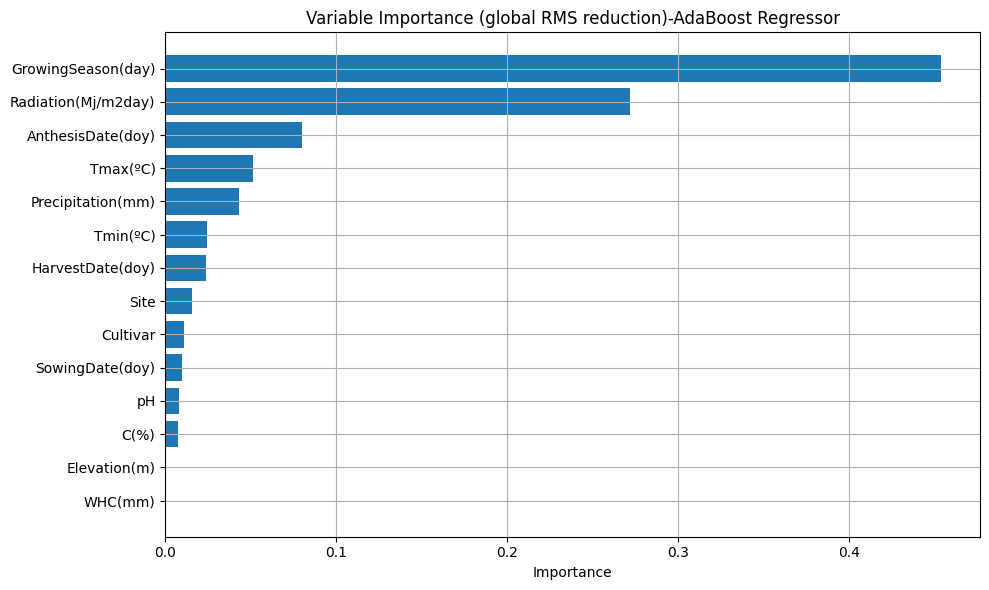

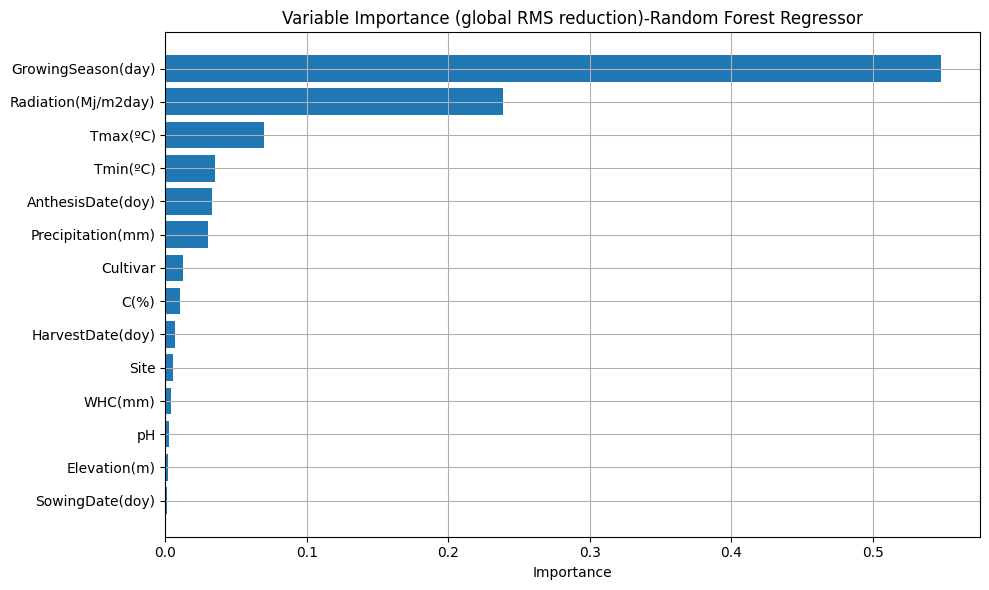

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [ ]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-05-18 09:37:44,955] A new study created in memory with name: no-name-57a39482-0a02-43c9-b8a6-71e59c6336cf


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:45,690] Trial 0 finished with value: 1289.9205035700127 and parameters: {'learning_rate': 0.19806943097897073, 'num_leaves': 22, 'max_depth': 12, 'min_child_samples': 94, 'subsample': 0.9442638956808576, 'colsample_bytree': 0.8470626299938373}. Best is trial 0 with value: 1289.9205035700127.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train se

[I 2025-05-18 09:37:46,266] Trial 1 finished with value: 1184.0308348664785 and parameters: {'learning_rate': 0.15811584580025673, 'num_leaves': 139, 'max_depth': 5, 'min_child_samples': 5, 'subsample': 0.8244294193273944, 'colsample_bytree': 0.7531682470427209}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15323.071582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:47,131] Trial 2 finished with value: 1197.6297513343768 and parameters: {'learning_rate': 0.036741330070265726, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 14, 'subsample': 0.6070911613398435, 'colsample_bytree': 0.6364155108019265}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:47,463] Trial 3 finished with value: 1269.8835323747721 and parameters: {'learning_rate': 0.20475343452206626, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 85, 'subsample': 0.518970331293427, 'colsample_bytree': 0.6487678992715229}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:47,834] Trial 4 finished with value: 1196.7790821486574 and parameters: {'learning_rate': 0.2386427540385187, 'num_leaves': 147, 'max_depth': 6, 'min_child_samples': 17, 'subsample': 0.6928128318088145, 'colsample_bytree': 0.5220577344746551}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15281.545695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2025-05-18 09:37:48,141] Trial 5 finished with value: 1254.6005916526908 and parameters: {'learning_rate': 0.2627971125841991, 'num_leaves': 26, 'max_depth': 15, 'min_child_samples': 60, 'subsample': 0.8537060003824078, 'colsample_bytree': 0.5028763242117099}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:48,465] Trial 6 finished with value: 1268.6185670852856 and parameters: {'learning_rate': 0.24165782383924972, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.828396888016361, 'colsample_bytree': 0.7984824766084686}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:48,969] Trial 7 finished with value: 1229.3779262327198 and parameters: {'learning_rate': 0.07895659254295691, 'num_leaves': 136, 'max_depth': 13, 'min_child_samples': 51, 'subsample': 0.6068283873570247, 'colsample_bytree': 0.5178363238760666}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:49,426] Trial 8 finished with value: 1310.387417464416 and parameters: {'learning_rate': 0.03844953749891928, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.7241326502418869, 'colsample_bytree': 0.7421865810858542}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:49,863] Trial 9 finished with value: 1373.5996726221233 and parameters: {'learning_rate': 0.06250977819138118, 'num_leaves': 151, 'max_depth': 9, 'min_child_samples': 96, 'subsample': 0.6335029634066216, 'colsample_bytree': 0.6132605925373851}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

[I 2025-05-18 09:37:50,392] Trial 10 finished with value: 1224.1853971089213 and parameters: {'learning_rate': 0.12690086459050626, 'num_leaves': 191, 'max_depth': 3, 'min_child_samples': 26, 'subsample': 0.9846440889114283, 'colsample_bytree': 0.9732093089750551}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:50,869] Trial 11 finished with value: 1206.1024620523488 and parameters: {'learning_rate': 0.29765699940358503, 'num_leaves': 175, 'max_depth': 3, 'min_child_samples': 6, 'subsample': 0.741948732502149, 'colsample_bytree': 0.7341559177729405}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15323.071582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:51,596] Trial 12 finished with value: 1192.7218568391545 and parameters: {'learning_rate': 0.15065524634200433, 'num_leaves': 162, 'max_depth': 5, 'min_child_samples': 28, 'subsample': 0.8340611229574236, 'colsample_bytree': 0.8622777694696319}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-18 09:37:52,492] Trial 13 finished with value: 1194.9374418083062 and parameters: {'learning_rate': 0.1317716915982447, 'num_leaves': 170, 'max_depth': 5, 'min_child_samples': 31, 'subsample': 0.857371612072224, 'colsample_bytree': 0.9101578400333087}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-18 09:37:52,808] Trial 14 finished with value: 1188.810293247689 and parameters: {'learning_rate': 0.1544990279625005, 'num_leaves': 71, 'max_depth': 10, 'min_child_samples': 35, 'subsample': 0.7946401690330884, 'colsample_bytree': 0.8586885778771466}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:53,139] Trial 15 finished with value: 1209.3884487883158 and parameters: {'learning_rate': 0.10022634628352305, 'num_leaves': 64, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.909437711854523, 'colsample_bytree': 0.9758984884025785}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15281.545695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-18 09:37:53,443] Trial 16 finished with value: 1216.4165939171075 and parameters: {'learning_rate': 0.18596589390469603, 'num_leaves': 63, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.7866385961411015, 'colsample_bytree': 0.7978817768669554}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:53,834] Trial 17 finished with value: 1211.5035688037556 and parameters: {'learning_rate': 0.1831454318827878, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 9, 'subsample': 0.7812126572525878, 'colsample_bytree': 0.6910856175909565}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-18 09:37:54,100] Trial 18 finished with value: 1273.7686397217267 and parameters: {'learning_rate': 0.10709573306125417, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 74, 'subsample': 0.676313510352768, 'colsample_bytree': 0.8978074592837044}. Best is trial 1 with value: 1184.0308348664785.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:54,476] Trial 19 finished with value: 1176.5769628624435 and parameters: {'learning_rate': 0.15765237898423606, 'num_leaves': 44, 'max_depth': 11, 'min_child_samples': 21, 'subsample': 0.897891165336061, 'colsample_bytree': 0.8012946259517014}. Best is trial 19 with value: 1176.5769628624435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:54,872] Trial 20 finished with value: 1180.575157120856 and parameters: {'learning_rate': 0.16937949735500926, 'num_leaves': 44, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.9055401516814031, 'colsample_bytree': 0.7847474061543915}. Best is trial 19 with value: 1176.5769628624435.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:55,277] Trial 21 finished with value: 1170.0738914932767 and parameters: {'learning_rate': 0.15656773478404942, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.9045729131394283, 'colsample_bytree': 0.7900588572469037}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-18 09:37:55,655] Trial 22 finished with value: 1200.8181512604028 and parameters: {'learning_rate': 0.22364617743362808, 'num_leaves': 41, 'max_depth': 13, 'min_child_samples': 22, 'subsample': 0.9114179782546455, 'colsample_bytree': 0.8003822800483674}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train se

[I 2025-05-18 09:37:56,038] Trial 23 finished with value: 1181.1286391034314 and parameters: {'learning_rate': 0.1640287770735954, 'num_leaves': 47, 'max_depth': 12, 'min_child_samples': 20, 'subsample': 0.991082538994909, 'colsample_bytree': 0.7118181242091051}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15281.545695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:56,335] Trial 24 finished with value: 1202.7204979398084 and parameters: {'learning_rate': 0.12587641528019355, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 43, 'subsample': 0.9190663787244828, 'colsample_bytree': 0.7858724814923818}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:56,800] Trial 25 finished with value: 1189.0247136261153 and parameters: {'learning_rate': 0.17118151253997546, 'num_leaves': 79, 'max_depth': 15, 'min_child_samples': 15, 'subsample': 0.9423830981000565, 'colsample_bytree': 0.9213113091896017}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:57,188] Trial 26 finished with value: 1194.243259120786 and parameters: {'learning_rate': 0.214319499195177, 'num_leaves': 48, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8745218108176783, 'colsample_bytree': 0.8409938871655186}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:57,642] Trial 27 finished with value: 1179.7836485350194 and parameters: {'learning_rate': 0.09964350981038184, 'num_leaves': 81, 'max_depth': 13, 'min_child_samples': 13, 'subsample': 0.8912915907328602, 'colsample_bytree': 0.6766533579426246}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 15270.718054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:58,197] Trial 28 finished with value: 1638.242209532973 and parameters: {'learning_rate': 0.011093666794397494, 'num_leaves': 84, 'max_depth': 14, 'min_child_samples': 11, 'subsample': 0.9561583596817835, 'colsample_bytree': 0.6798325672028435}. Best is trial 21 with value: 1170.0738914932767.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 15344.879593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-18 09:37:58,504] Trial 29 finished with value: 1170.2431561729911 and parameters: {'learning_rate': 0.09424661440307443, 'num_leaves': 22, 'max_depth': 11, 'min_child_samples': 33, 'subsample': 0.8883292395709359, 'colsample_bytree': 0.5724538705509821}. Best is trial 21 with value: 1170.0738914932767.
[I 2025-05-18 09:37:58,505] A new study created in memory with name: no-name-131a91d8-adea-4ea1-94a1-298d09564437


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-18 09:37:59,438] Trial 0 finished with value: 1169.7868079842422 and parameters: {'learning_rate': 0.14230296283925545, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.8453854595041673, 'colsample_bytree': 0.9556219227553602}. Best is trial 0 with value: 1169.7868079842422.
[I 2025-05-18 09:37:59,755] Trial 1 finished with value: 1191.5275788433653 and parameters: {'learning_rate': 0.10118094729012031, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5566822308740049, 'colsample_bytree': 0.5950973769101028}. Best is trial 0 with value: 1169.7868079842422.
[I 2025-05-18 09:38:00,650] Trial 2 finished with value: 1205.7867795841828 and parameters: {'learning_rate': 0.21443985218648706, 'max_depth': 13, 'min_child_weight': 10, 'subsample': 0.9683970254030498, 'colsample_bytree': 0.9904447520219619}. Best is trial 0 with value: 1169.7868079842422.
[I 2025-05-18 09:38:01,422] Trial 3 finished with value: 1161.9935122702686 and parameters: {'learning_rate': 0.059228646

# 🚀 Regressors Training on Optimized Models

In [ ]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 15307.825496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

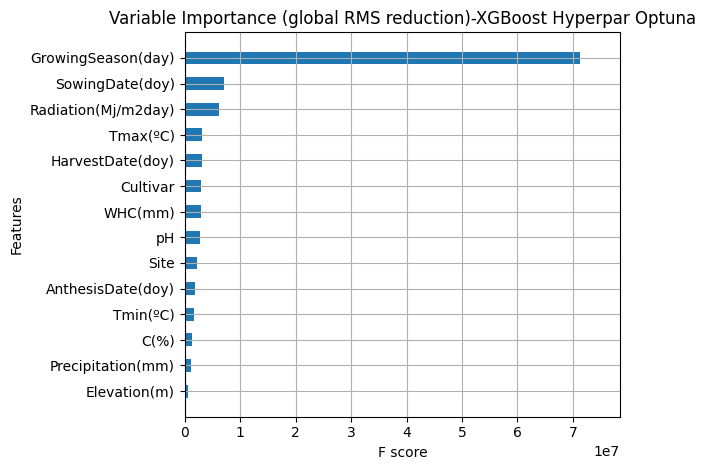

In [ ]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

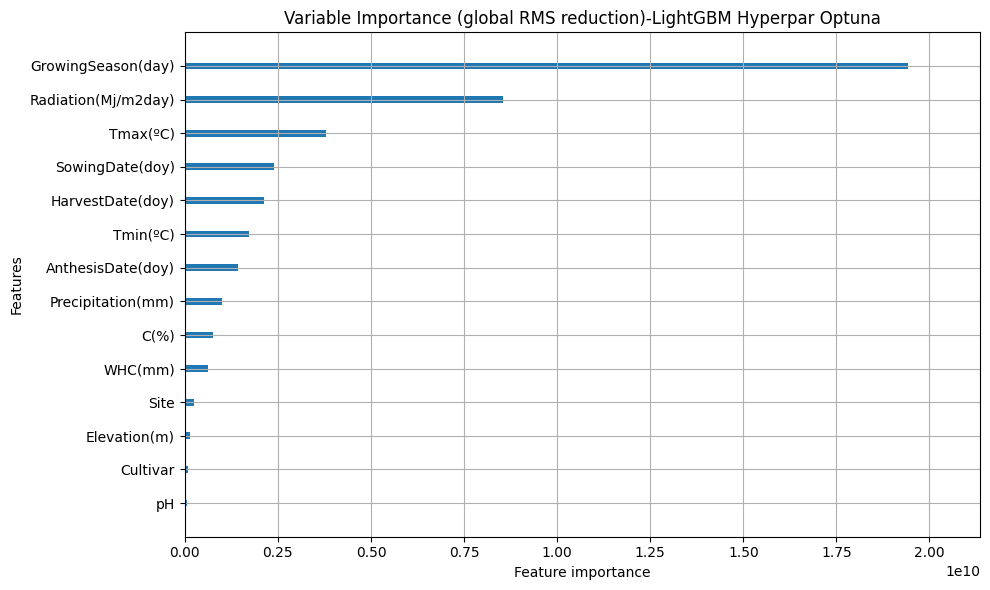

In [ ]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


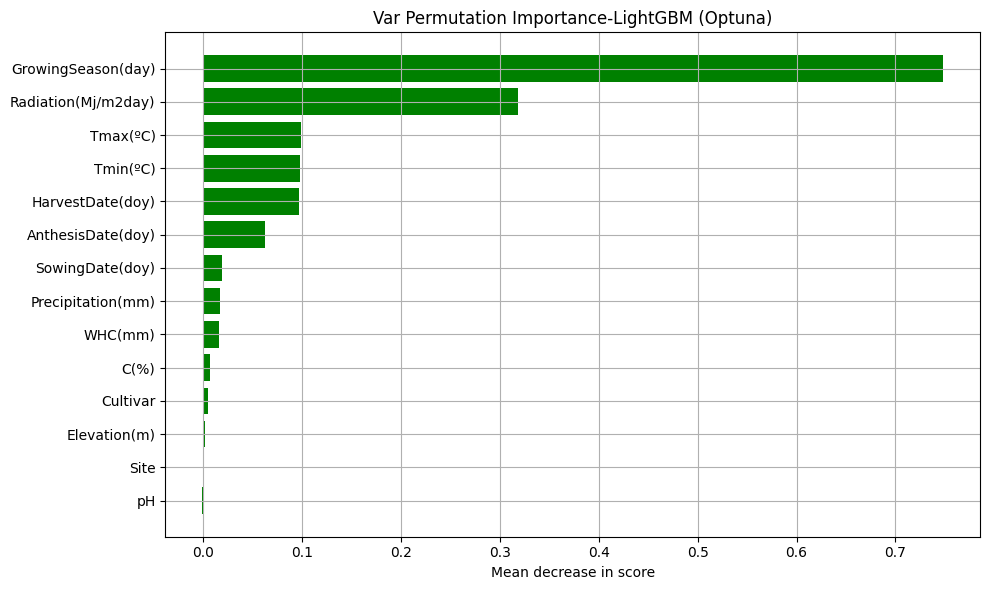

Var Permutation Importance-XGBoost (Optuna)


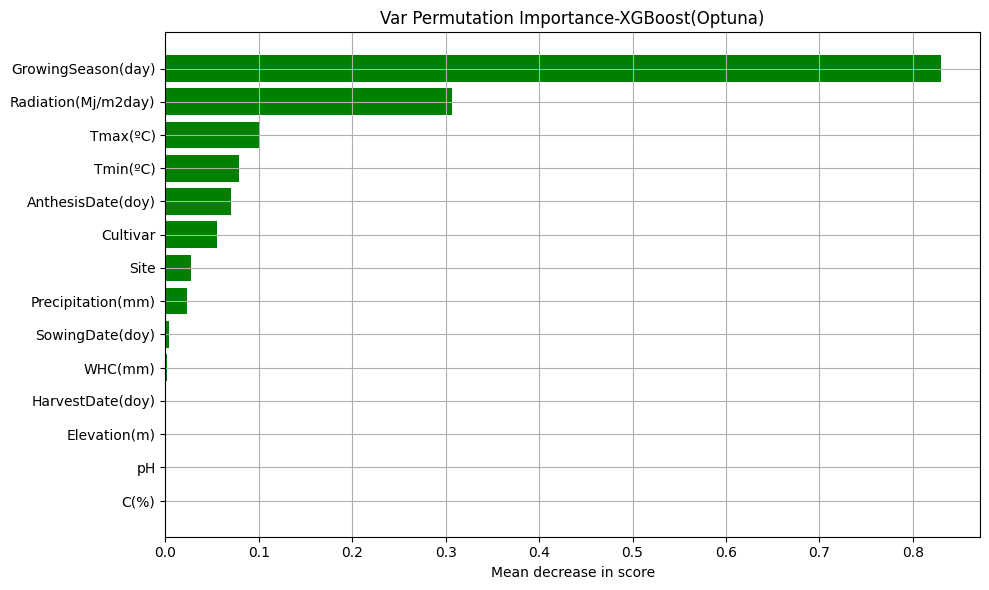

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx],color='green')
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


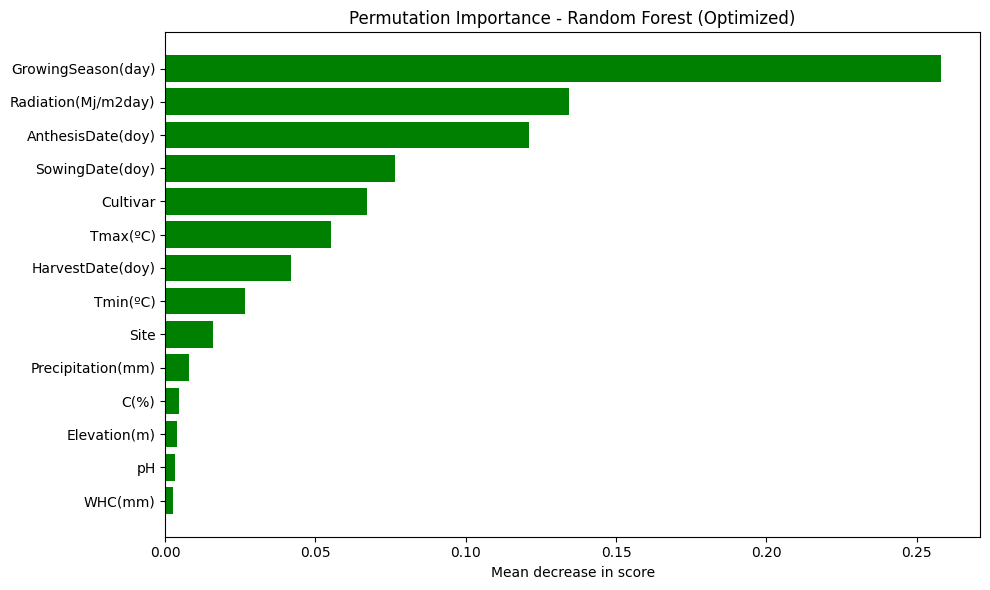

In [ ]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'],color='green')
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



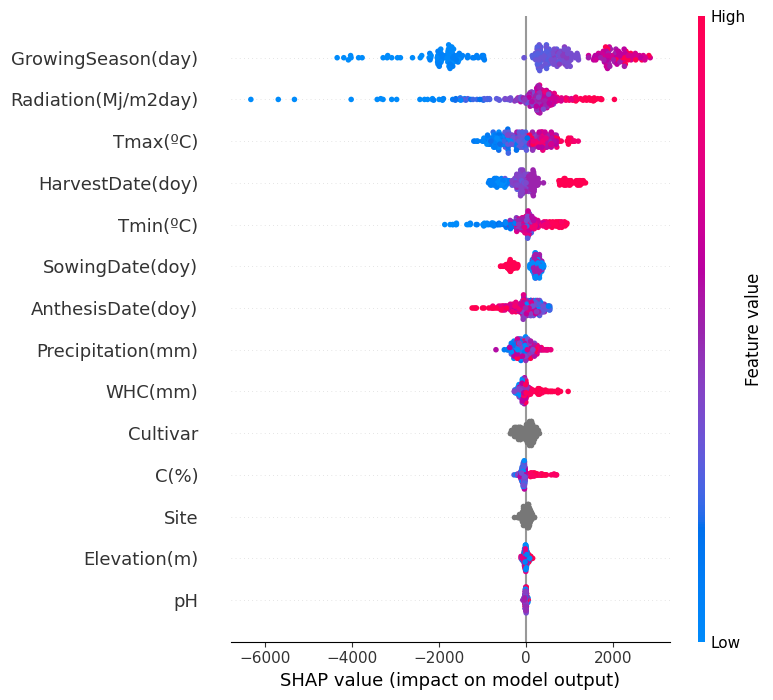

In [ ]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

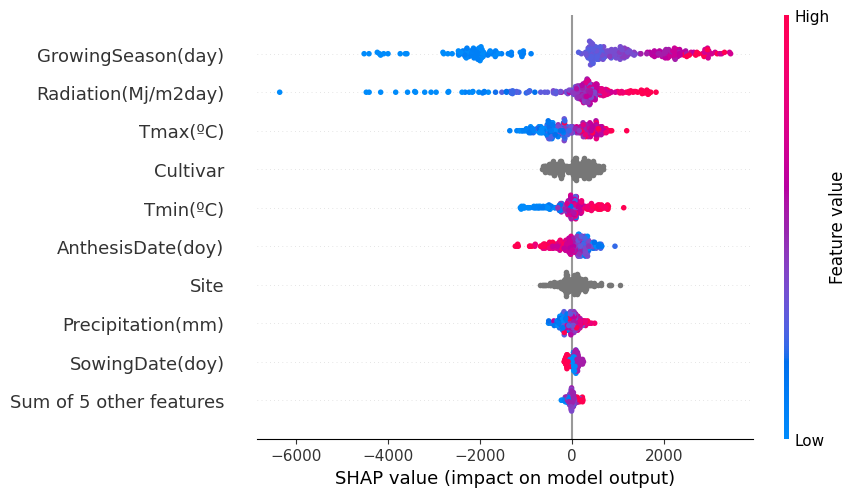

In [ ]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [ ]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


In [ ]:
try:
  lgb_best.booster_.save_model("DM_lgb_best_model.txt")
except Exception as e:
    print("❌ Error saving the model LightGBM:", e)

## PREDICTION

In [ ]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
import joblib
try:
    lgb_loaded = joblib.load("lgb_best_model.pkl")
except Exception as e:
    print("❌ Error al cargar el modelo LightGBM:", e)
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

columnas = ['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)','Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)','GrowingSeason(day)']

datos = [['Barcia','A200',25,21,56.6,20.5,16.7,90,1.8999999999999997,5.200000000000003,133,228.70531400966183,250,117]]

print(len(columnas))
print(len(datos))

# Crear DataFrame
X_nuevos_datos = pd.DataFrame(datos, columns=columnas)
X_nuevos_datos["Site"] = X_nuevos_datos["Site"].astype("category")
X_nuevos_datos["Cultivar"] = X_nuevos_datos["Cultivar"].astype("category")

# Reemplazar X_nuevos_datos por datos reales
y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
print(y_pred_lgb)
print(y_pred_xgb)

14
1
[14949.64572422]
[15410.743]
